In [1]:
%matplotlib widget
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
import os
import math
import operator
import copy

from osgeo import gdal, gdal_array

from preprocess import data_extractor, resize_ndvi
from skimage.segmentation import felzenszwalb
from evolution_graph import evolution_graph_ndvi
from matplotlib import pyplot as plt
from utilefunc.get_palette import get_palette
from utilefunc.get_band_order_GS2 import get_band_order_GS2
from utilefunc.resample import resample

## All pin notes data information

In [2]:
pin_notes = gpd.read_file('pinnote_info/seasonfieldpinnote_seasonfieldpinnote_r7_202004081314.geojson')
pin_notes = pin_notes.astype({'spn_idseasonfieldr7':'int64'})
pin_notes['year'] = pd.to_datetime(pin_notes['spn_createdon'].values, format='%m/%d/%Y %H:%M').year
pin_notes

,spn_id,spn_idseasonfieldr7,spn_iduser,spn_pinpoint,spn_note,spn_createdon,spn_idmapr7,spn_displaynumber,spn_severity,spn_idrxmapr7,geometry,year
0,2,101585255,100002344,POINT (-94.85356450080911 42.60094077629686),test note 1,4/6/2017 4:33,,1,NORMAL,,POINT (-94.85356 42.60094),2017
1,45,101541434,100005272,POINT (-94.8740136623385 40.878737313274875),Gate,4/7/2017 8:01,,4,NORMAL,,POINT (-94.87401 40.87874),2017
2,4,101410478,100002344,POINT (-85.02536058425905 40.630450951751385),another note,4/6/2017 6:21,,1,NORMAL,,POINT (-85.02536 40.63045),2017
3,6,101493634,100002344,POINT (-95.3408360481263 41.09853166121577),klll,4/6/2017 6:28,,1,NORMAL,,POINT (-95.34084 41.09853),2017
4,141,101430389,100009189,POINT (-100.24672508239773 40.95844677728032),Scouted this,4/17/2017 14:31,,1,NORMAL,,POINT (-100.24673 40.95845),2017
...,...,...,...,...,...,...,...,...,...,...,...,...
7114,18527,103016874,100104160,POINT (-97.37879455089559 38.2474596585408),.38\n0 rate block\n\n2-4 tillers,3/4/2020 20:45,,3,HIGH,,POINT (-97.37879 38.24746),2020
7115,18585,103351088,100005717,POINT (-95.1494808197022 41.13265459247429),notey,3/28/2020 11:03,,2,HIGH,,POINT (-95.14948 41.13265),2020
7116,18600,103117120,100009632,POINT (-95.6259784667055 39.77353590065879),Weedy patch,3/28/2020 12:39,,1,HIGH,,POINT (-95.62598 39.77354),2020
7117,18607,103210330,100009632,POINT (-95.54520749967155 39.79763791632599),Test,3/28/2020 14:02,,1,HIGH,,POINT (-95.54521 39.79764),2020


In [3]:
pin_notes.spn_idseasonfieldr7.unique().size

2247

In [4]:
pin_notes[(pin_notes.spn_severity != 'NORMAL') & (pin_notes.spn_note != '')]

,spn_id,spn_idseasonfieldr7,spn_iduser,spn_pinpoint,spn_note,spn_createdon,spn_idmapr7,spn_displaynumber,spn_severity,spn_idrxmapr7,geometry,year
144,6511,102051362,100009548,POINT (-99.97880458831744 49.18411581319375),Drown out,1/25/2018 10:39,,1,MEDIUM,,POINT (-99.97880 49.18412),2018
145,425,101407670,100009632,POINT (-95.54989814758306 39.76434576157241),;oiauwoidufoiuewr09,5/12/2017 11:07,,4,HIGH,,POINT (-95.54990 39.76435),2017
154,6512,102040745,100009548,POINT (-97.52503395080564 49.154183600759794),Weed,1/25/2018 14:03,,2,HIGH,,POINT (-97.52503 49.15418),2018
182,6513,102048852,100002436,POINT (-94.60357189178451 43.728824612512994),kojojoijoji,1/25/2018 14:12,,3,HIGH,,POINT (-94.60357 43.72882),2018
262,1661,101900018,100058768,POINT (-99.61827278137241 46.135463683255814),"Nitrate 0-6"" - 35lb Nitrate 6-24""- 33lb Phosph...",7/26/2017 14:18,,30,HIGH,,POINT (-99.61827 46.13546),2017
...,...,...,...,...,...,...,...,...,...,...,...,...
7112,18581,103016874,100104160,POINT (-97.3782956600185 38.24752917161402),.58 in between 0 rate block and n rich strip....,3/25/2020 22:24,,11,MEDIUM,,POINT (-97.37830 38.24753),2020
7114,18527,103016874,100104160,POINT (-97.37879455089559 38.2474596585408),.38\n0 rate block\n\n2-4 tillers,3/4/2020 20:45,,3,HIGH,,POINT (-97.37879 38.24746),2020
7115,18585,103351088,100005717,POINT (-95.1494808197022 41.13265459247429),notey,3/28/2020 11:03,,2,HIGH,,POINT (-95.14948 41.13265),2020
7116,18600,103117120,100009632,POINT (-95.6259784667055 39.77353590065879),Weedy patch,3/28/2020 12:39,,1,HIGH,,POINT (-95.62598 39.77354),2020


## Anomaly notes analysis

In [5]:
# word_freq = pd.value_counts([el for x in new_data['spn_note'].apply(lambda x: x.lower().strip().split('\n')).apply(lambda x: [y.split(' ') for y in x]) for i in x for el in i]).to_frame()
word_freq = pd.value_counts([el for x in pin_notes[pin_notes.spn_severity != 'NORMAL']['spn_note'].apply(lambda x: x.lower().strip().split('\n')).apply(lambda x: [y.split(' ') for y in x]) for i in x for el in i]).to_frame()
word_freq.columns = ['frequence']
# word_freq.head(60)

In [6]:
#word_freq.to_dict()['frequence']

In [7]:
anomaly = ['wet', 'water', 'drown', 'drought', 'drain', 'dry', 'weed', 'grass', 'disease', 'worm', 'pest', 'bug', 'insect', 'white mold','spider mite', 'beetle', 'deficiency', 'problem']

## Extracted data general information

In [8]:
all_data = gpd.read_file('pinnote_info/pinnotes_non-empty_flag-pin-in-field.geojson')
all_data['year'] = pd.to_datetime(all_data['spn_createdon'].values, format='%m/%d/%Y %H:%M').year
all_data

,spn_id,spn_idseasonfieldr7,spn_iduser,spn_note,spn_createdon,spn_idmapr7,spn_displaynumber,spn_severity,spn_idrxmapr7,sfd_id,pin_in_field,geometry,year
0,2,101585255,100002344,test note 1,4/6/2017 4:33,,1,NORMAL,,101585255,True,POINT (-94.85356 42.60094),2017
1,1311,101585255,100002344,jhgdqhdshdsq,7/11/2017 5:11,,2,HIGH,,101585255,True,POINT (-94.84662 42.60207),2017
2,45,101541434,100005272,Gate,4/7/2017 8:01,,4,NORMAL,,101541434,False,POINT (-94.87401 40.87874),2017
3,46,101541434,100005272,Gate,4/7/2017 8:01,,5,NORMAL,,101541434,True,POINT (-94.87677 40.87865),2017
4,47,101541434,100005272,Gate,4/7/2017 8:02,,6,NORMAL,,101541434,False,POINT (-94.87443 40.87430),2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4664,18574,103016856,100104160,".48 \nWhole field looks good. Nice stand, even...",3/25/2020 18:24,,4,MEDIUM,,103016856,True,POINT (-97.26680 38.17792),2020
4665,18575,103016856,100104160,.55 n rich strip,3/25/2020 18:30,,5,NORMAL,,103016856,True,POINT (-97.26448 38.17792),2020
4666,18585,103351088,100005717,notey,3/28/2020 11:03,,2,HIGH,,103351088,True,POINT (-95.14948 41.13265),2020
4667,18607,103210330,100009632,Test,3/28/2020 14:02,,1,HIGH,,103210330,True,POINT (-95.54521 39.79764),2020


In [9]:
all_data.sfd_id.unique().size

1740

In [10]:
all_data[all_data.spn_severity != 'NORMAL'].sfd_id.unique().size

555

### Ids of fields with data

In [11]:
data_path = 'data_images_2017_2020/'
sfd_ids = os.listdir(data_path)
selected_data = all_data.iloc[[i for i in range(len(all_data)) if str(all_data.spn_idseasonfieldr7[i]) in sfd_ids],:].copy(deep=True)

In [12]:
len(sfd_ids)

1352

### Join croptype to the dataframe

In [13]:
all_crop_codes = pd.read_csv('pinnote_info/TEST-2021-08-03-13-50-35_historical_croptype_2017_2020.csv', sep=';')
all_crop_codes

,Field,Year,Croptype,Quality,Source
0,100247642,2017,Corn,1.0,CDL
1,100247642,2018,Soybeans,1.0,CDL
2,100247642,2019,Corn,1.0,CDL
3,100247642,2020,Soybeans,1.0,CDL
4,100358772,2017,Corn,1.0,CDL
...,...,...,...,...,...
6955,103448510,2020,Barley,1.0,CDL
6956,103448867,2017,Cotton,1.0,CDL
6957,103448867,2018,Cotton,1.0,CDL
6958,103448867,2019,Cotton,1.0,CDL


In [14]:
selected_data['croptype'] = [all_crop_codes[(all_crop_codes.Field == selected_data.iloc[i].spn_idseasonfieldr7) & (all_crop_codes.Year == selected_data.iloc[i].year)].Croptype.values[0] for i in range(len(selected_data))]
selected_data

,spn_id,spn_idseasonfieldr7,spn_iduser,spn_note,spn_createdon,spn_idmapr7,spn_displaynumber,spn_severity,spn_idrxmapr7,sfd_id,pin_in_field,geometry,year,croptype
135,6511,102051362,100009548,Drown out,1/25/2018 10:39,,1,MEDIUM,,102051362,True,POINT (-99.97880 49.18412),2018,NaN
142,6512,102040745,100009548,Weed,1/25/2018 14:03,,2,HIGH,,102040745,True,POINT (-97.52503 49.15418),2018,NaN
143,6468,102040745,100009548,Drown out area,1/17/2018 13:55,,1,MEDIUM,,102040745,True,POINT (-97.51821 49.15364),2018,NaN
159,20171,103448867,100007796,Test Note,4/6/2020 17:22,,1,NORMAL,,103448867,True,POINT (-89.02042 35.24493),2020,Cotton
194,6513,102048852,100002436,kojojoijoji,1/25/2018 14:12,,3,HIGH,,102048852,True,POINT (-94.60357 43.72882),2018,Corn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4664,18574,103016856,100104160,".48 \nWhole field looks good. Nice stand, even...",3/25/2020 18:24,,4,MEDIUM,,103016856,True,POINT (-97.26680 38.17792),2020,Dbl Crop WinWht/Soybeans
4665,18575,103016856,100104160,.55 n rich strip,3/25/2020 18:30,,5,NORMAL,,103016856,True,POINT (-97.26448 38.17792),2020,Dbl Crop WinWht/Soybeans
4666,18585,103351088,100005717,notey,3/28/2020 11:03,,2,HIGH,,103351088,True,POINT (-95.14948 41.13265),2020,Soybeans
4667,18607,103210330,100009632,Test,3/28/2020 14:02,,1,HIGH,,103210330,True,POINT (-95.54521 39.79764),2020,Corn


In [15]:
# save the available sfd_ids in .csv file
# pd.Series(selected_data.spn_idseasonfieldr7.unique().tolist(), name='sfd_id').to_csv('pinnote_info/pinnotes_non-empty_seasonfield_with_data.csv', sep=';')

In [16]:
selected_data[selected_data.spn_severity != 'NORMAL'].sfd_id.unique().size

460

In [17]:
dict_freq = dict()
count = 0
for i in range(len(selected_data)):
    for x in anomaly:
        if x in selected_data.iloc[i].spn_note.lower():
            dict_freq[x] = dict_freq.get(x, []) + [i]
            count += 1
print({k:len(v) for k,v in dict_freq.items()})
print(count)

{'drown': 19, 'weed': 212, 'worm': 17, 'wet': 49, 'disease': 19, 'grass': 96, 'deficiency': 20, 'water': 50, 'problem': 6, 'dry': 18, 'white mold': 3, 'bug': 23, 'drain': 8, 'insect': 18, 'pest': 20, 'spider mite': 4, 'beetle': 6, 'drought': 2}
590


In [18]:
sfd_inds = []
selected_data['anomaly'] = 'unknown'
for k,v in dict_freq.items():
    sfd_inds += v
    selected_data['anomaly'].iloc[v] = k
anomaly_to_verify = selected_data.iloc[sfd_inds, :].copy(deep=True)
anomaly_sfd_ids = anomaly_to_verify.sfd_id.unique().tolist()

anomaly_to_verify

C:\Users\qle\AppData\Local\Temp\ipykernel_21488\2896840626.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['anomaly'].iloc[v] = k


,spn_id,spn_idseasonfieldr7,spn_iduser,spn_note,spn_createdon,spn_idmapr7,spn_displaynumber,spn_severity,spn_idrxmapr7,sfd_id,pin_in_field,geometry,year,croptype,anomaly
135,6511,102051362,100009548,Drown out,1/25/2018 10:39,,1,MEDIUM,,102051362,True,POINT (-99.97880 49.18412),2018,NaN,drown
143,6468,102040745,100009548,Drown out area,1/17/2018 13:55,,1,MEDIUM,,102040745,True,POINT (-97.51821 49.15364),2018,NaN,drown
684,7578,102174002,100002480,Double check drowned spot with Chad,4/4/2018 14:12,,1,HIGH,,102174002,True,POINT (-86.89443 34.61873),2018,Dbl Crop WinWht/Soybeans,drown
992,6632,102077408,100009548,DROWN OUT AREA,2/12/2018 10:11,,1,NORMAL,,102077408,True,POINT (-99.64896 47.63578),2018,Spring Wheat,drown
1234,6577,102065471,100009548,Drown out,2/2/2018 12:30,,1,HIGH,,102065471,True,POINT (-99.53152 47.79605),2018,Spring Wheat,drown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4129,17374,102576009,100009599,Japanese beetle pressure,7/17/2019 2:45,,1,HIGH,,102576009,True,POINT (-96.40494 40.99657),2019,Corn,beetle
4183,17542,102943146,100093984,Large presence or Japanese beetles.\nNoticed f...,7/29/2019 19:31,,1,MEDIUM,,102943146,False,POINT (-87.94784 37.64623),2019,Corn,beetle
4184,17543,102943146,100093984,Large presence of Japanese beetles.\nMedium pr...,7/29/2019 19:36,,2,MEDIUM,,102943146,False,POINT (-87.94891 37.64368),2019,Corn,beetle
3233,14892,102620833,100002497,"Drought spot, fewer plants\nNutrient deficienc...",2/8/2019 21:29,,1,HIGH,,102620833,True,POINT (-88.70326 42.29836),2019,Corn,drought


In [19]:
# anomaly_to_verify.to_file('pinnote_anomaly_info/anomaly_to_verify.geojson', driver='GeoJSON', encoding='utf-8')

In [20]:
anomaly_to_verify.sfd_id.unique().size

357

In [21]:
selected_data.iloc[dict_freq['insect']].loc[:,['spn_id','spn_idseasonfieldr7','spn_note', 'spn_createdon', 'spn_severity', 'croptype', 'anomaly']]

,spn_id,spn_idseasonfieldr7,spn_note,spn_createdon,spn_severity,croptype,anomaly
1856,6177,102018937,insect feeding on leaves,12/6/2017 13:11,MEDIUM,Sunflower,insect
2020,6457,102037298,Poor stand running behind and insect pressure,1/16/2018 8:50,NORMAL,Corn,insect
2825,11246,102160338,beans look good but there is some insect press...,7/19/2018 12:09,NORMAL,Soybeans,insect
2914,11676,102403591,Pollination almost complete but signs of big d...,8/15/2018 16:00,MEDIUM,Corn,insect
3199,14728,102676378,Heavy insect pressure,1/14/2019 20:44,MEDIUM,Corn,insect
3217,14830,102562682,Insect_:,1/31/2019 17:49,HIGH,Cotton,insect
3511,15326,102726181,Insect spray,3/19/2019 21:52,HIGH,Grapes,insect
3939,16568,102509901,Tissue sample was taken here. Corn is in the V...,6/11/2019 13:14,NORMAL,Corn,insect
3945,16574,102729823,"Tissue sample taken here, corn is at the V6 gr...",6/11/2019 14:36,NORMAL,Corn,insect
3948,16576,102491414,Tissue sample taken here. Corn is at the V5 gr...,6/11/2019 15:09,NORMAL,Corn,insect


### Validation of anomalies

In [22]:
all_annotations = pd.read_csv('pinnote_anomaly_info/verified_anomaly.csv', sep=';')
all_annotations = all_annotations.astype({'spn_id':'string'})
all_annotations

,spn_id,sfd_id,year,anomaly_type,validation,comments
0,6079,102002072,2017,Wet,not obvious,NaN
1,6081,102002072,2017,Wet,not obvious,NaN
2,6096,102008096,2017,Grass,not obvious,NaN
3,6106,102009906,2017,Bug,not obvious,NaN
4,6162,102015662,2017,Weed,not obvious,NaN
...,...,...,...,...,...,...
382,18479,103386958,2020,Bug,not obvious,NaN
383,18533,103016841,2020,"Dry, drought","obvious, not well segmented",NaN
384,18540,103016841,2020,"Dry, drought","obvious, not well segmented",NaN
385,18572,103016856,2020,"Deficiency, problem",not obvious,NaN


In [23]:
annotations = all_annotations[all_annotations.validation != 'not obvious'].copy(deep=True)
annotations.head(10)

,spn_id,sfd_id,year,anomaly_type,validation,comments
11,6413,102000576,2017,Drown,"obvious, well segmented",NaN
26,6548,102058667,2018,Wet,"obvious, well segmented",anomaly date before time series
32,6632,102077408,2018,Drown,"obvious, not well segmented",NaN
39,6959,102112829,2018,Wet,"obvious, not well segmented",NaN
42,6991,102002234,2018,Wet,"obvious, not well segmented",NaN
43,6994,102006400,2018,Bug,"obvious, not well segmented",NaN
45,7070,102130079,2018,Water,"obvious, well segmented",NaN
51,7480,102112067,2018,Water,"obvious, well segmented",NaN
52,7482,102066519,2018,Water,"obvious, well segmented",NaN
58,7578,102174002,2018,Drown,"obvious, well segmented",NaN


In [24]:
print(f'total annotations: {len(annotations)}')
print(f'total fields: {annotations.sfd_id.unique().size}')

total annotations: 57
total fields: 47


In [25]:
annotations.groupby('anomaly_type').count().index

Index(['Beetle', 'Bug', 'Deficiency, problem', 'Disease', 'Drain', 'Drown ',
       'Dry, drought', 'Grass', 'Spider mite', 'Water ', 'Wet', 'White mold'],
      dtype='object', name='anomaly_type')

In [26]:
annotations.groupby('anomaly_type').count()['spn_id']

anomaly_type
Beetle                  2
Bug                     1
Deficiency, problem     2
Disease                 2
Drain                   3
Drown                   5
Dry, drought           10
Grass                   4
Spider mite             1
Water                  13
Wet                    12
White mold              2
Name: spn_id, dtype: int64

In [27]:
annotations['anomaly_class'] = None
for i in range(len(annotations)):
    if annotations.iloc[i]['anomaly_type'].rstrip() in ['Water', 'Wet', 'Drain', 'Drown']:
        annotations['anomaly_class'].iloc[i] = 'humid'
    elif annotations.iloc[i]['anomaly_type'].rstrip() in ['Dry, drought']:
        annotations['anomaly_class'].iloc[i] = 'dry'
    elif annotations.iloc[i]['anomaly_type'].rstrip() in ['Weed', 'Grass']:
        annotations['anomaly_class'].iloc[i] = 'weed'
    elif annotations.iloc[i]['anomaly_type'].rstrip() in ['Deficiency, problem']:
        annotations['anomaly_class'].iloc[i] = 'deficiency'
    else:
        annotations['anomaly_class'].iloc[i] = 'insect'
annotations

C:\Users\qle\AppData\Local\Temp\ipykernel_21488\3204168223.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations['anomaly_class'].iloc[i] = 'humid'
C:\Users\qle\AppData\Local\Temp\ipykernel_21488\3204168223.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations['anomaly_class'].iloc[i] = 'insect'
C:\Users\qle\AppData\Local\Temp\ipykernel_21488\3204168223.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation

,spn_id,sfd_id,year,anomaly_type,validation,comments,anomaly_class
11,6413,102000576,2017,Drown,"obvious, well segmented",NaN,humid
26,6548,102058667,2018,Wet,"obvious, well segmented",anomaly date before time series,humid
32,6632,102077408,2018,Drown,"obvious, not well segmented",NaN,humid
39,6959,102112829,2018,Wet,"obvious, not well segmented",NaN,humid
42,6991,102002234,2018,Wet,"obvious, not well segmented",NaN,humid
43,6994,102006400,2018,Bug,"obvious, not well segmented",NaN,insect
45,7070,102130079,2018,Water,"obvious, well segmented",NaN,humid
51,7480,102112067,2018,Water,"obvious, well segmented",NaN,humid
52,7482,102066519,2018,Water,"obvious, well segmented",NaN,humid
58,7578,102174002,2018,Drown,"obvious, well segmented",NaN,humid


NameError: name 'func' is not defined

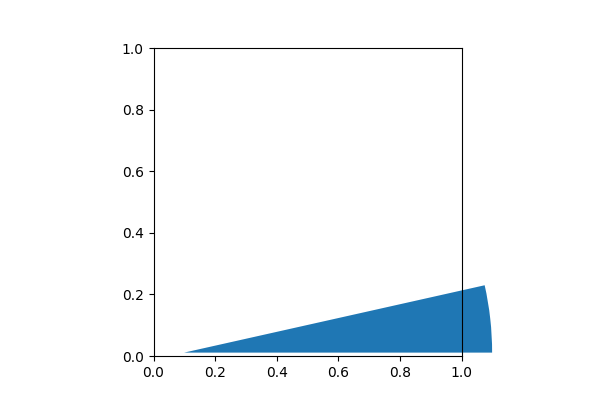

In [28]:
data = annotations.groupby('anomaly_class').count()['spn_id']
labels = annotations.groupby('anomaly_class').count().index
explode = np.ones((len(labels)))*0.1

plt.figure(figsize=(6,4))
wedges, texts, autotexts = plt.pie(data, autopct=lambda pct: func(pct, data), textprops=dict(color="k"), explode=explode)
plt.legend(wedges, labels, title="Anomaly class", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
plt.show()

In [ ]:
def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

data = annotations.groupby('anomaly_type').count()['spn_id']
labels = annotations.groupby('anomaly_type').count().index
explode = np.ones((len(labels)))*0.1
plt.figure(figsize=(10,6))
wedges, texts, autotexts = plt.pie(data, labels=labels, autopct=lambda pct: func(pct, data), textprops=dict(color="k"), explode=explode)
plt.setp(autotexts, size=8, weight="bold")
plt.show()

In [29]:
annotations_complete = pd.merge(selected_data, annotations, on=['spn_id', 'sfd_id'])
annotations_complete.drop(columns=['sfd_id', 'spn_iduser', 'spn_idmapr7', 'spn_displaynumber', 'spn_idrxmapr7', 'year_y', 'anomaly'], inplace=True)
annotations_complete.rename(columns={'spn_idseasonfieldr7':'sfd_id', 'year_x':'year'}, inplace=True)
annotations_complete

,spn_id,sfd_id,spn_note,spn_createdon,spn_severity,pin_in_field,geometry,year,croptype,anomaly_type,validation,comments,anomaly_class
0,8610,102247581,Grass hay. More grass than alfalfa\n\n6 stems,5/17/2018 0:24,NORMAL,True,POINT (-88.79054 43.00132),2018,Alfalfa,Grass,"obvious, well segmented",NaN,weed
1,8609,102247581,18 inches\n\n21 stems\n\nGrass alfalfa mix,5/17/2018 0:21,NORMAL,True,POINT (-88.79039 43.00196),2018,Alfalfa,Grass,"obvious, well segmented",NaN,weed
2,7578,102174002,Double check drowned spot with Chad,4/4/2018 14:12,HIGH,True,POINT (-86.89443 34.61873),2018,Dbl Crop WinWht/Soybeans,Drown,"obvious, well segmented",NaN,humid
3,8833,102202245,"33,000\nV1\nQuackgrass present",5/22/2018 19:54,NORMAL,True,POINT (-89.75951 45.04810),2018,Corn,Grass,"obvious, well segmented",NaN,weed
4,8837,102202245,"33,000 \nSome @VE but most at V1\nQuackgrass, ...",5/22/2018 20:01,NORMAL,True,POINT (-89.76461 45.04771),2018,Corn,Grass,"obvious, well segmented",NaN,weed
5,6548,102058667,Wet,1/30/2018 14:23,NORMAL,True,POINT (-99.27755 48.81574),2018,Soybeans,Wet,"obvious, well segmented",anomaly date before time series,humid
6,6632,102077408,DROWN OUT AREA,2/12/2018 10:11,NORMAL,True,POINT (-99.64896 47.63578),2018,Spring Wheat,Drown,"obvious, not well segmented",NaN,humid
7,6959,102112829,Didn't plant because it was wet,3/6/2018 11:04,NORMAL,True,POINT (-100.49260 38.47262),2018,Corn,Wet,"obvious, not well segmented",NaN,humid
8,6991,102002234,wet area,3/8/2018 14:17,MEDIUM,True,POINT (-100.37342 46.12747),2018,Peas,Wet,"obvious, not well segmented",NaN,humid
9,6994,102006400,Bug problem,3/9/2018 12:19,NORMAL,True,POINT (-111.82335 42.63970),2018,Alfalfa,Bug,"obvious, not well segmented",NaN,insect


In [30]:
annotations_complete['sfd_id'].unique().__len__()

47

57 pinnotes in 47 fields

In [31]:
# annotations_complete.to_file('pinnote_anomaly_info/annotations_valid.geojson', driver='GeoJSON')

In [32]:
annotations_complete['spn_createdon'] = annotations_complete['spn_createdon'].apply(lambda x:pd.to_datetime(x, format='%m/%d/%Y %H:%M'))

In [33]:
# annotations_complete.to_csv('pinnote_anomaly_info/annotations_valid_dates.csv', sep=';')

In [34]:
date_of_pinnotes = pd.to_datetime(annotations_complete['spn_createdon'].values, format='%m/%d/%Y %H:%M')

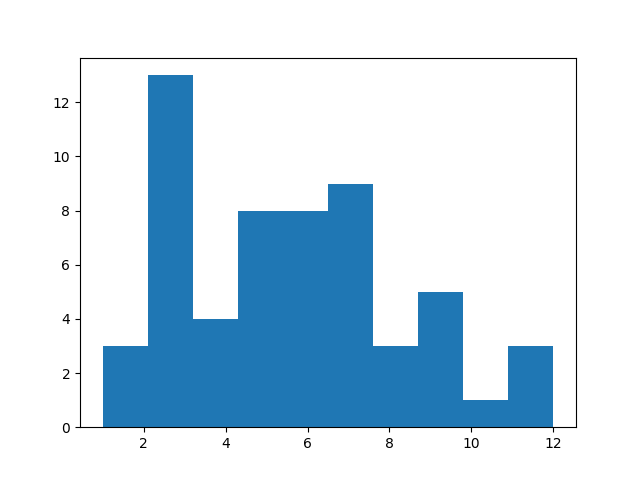

In [35]:
plt.figure()
plt.hist(date_of_pinnotes.month)
plt.show()

In [36]:
annotations_complete[annotations_complete.croptype.isna()].sfd_id.unique().size

1

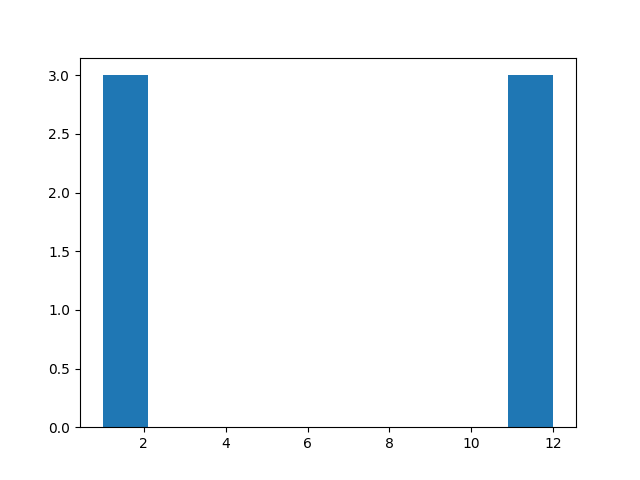

In [37]:
plt.figure()
plt.hist(date_of_pinnotes[(date_of_pinnotes.month<3) | (date_of_pinnotes.month>10)].month)
plt.show()

In [38]:
annotations_complete[(date_of_pinnotes.month<3) | (date_of_pinnotes.month>10)]

,spn_id,sfd_id,spn_note,spn_createdon,spn_severity,pin_in_field,geometry,year,croptype,anomaly_type,validation,comments,anomaly_class
5,6548,102058667,Wet,2018-01-30 14:23:00,NORMAL,True,POINT (-99.27755 48.81574),2018,Soybeans,Wet,"obvious, well segmented",anomaly date before time series,humid
6,6632,102077408,DROWN OUT AREA,2018-02-12 10:11:00,NORMAL,True,POINT (-99.64896 47.63578),2018,Spring Wheat,Drown,"obvious, not well segmented",NaN,humid
17,6413,102000576,"This area drowned out this year, what is going...",2017-12-22 07:12:00,HIGH,True,POINT (-82.76142 40.81662),2017,Soybeans,Drown,"obvious, well segmented",NaN,humid
35,14512,102645549,White Mold,2018-11-07 15:57:00,HIGH,True,POINT (-92.75935 44.26336),2018,Soybeans,White mold,"obvious, not well segmented",NaN,insect
36,14572,102536577,Water damage,2018-11-14 02:31:00,HIGH,True,POINT (-79.20446 34.53898),2018,Corn,Water,"obvious, not well segmented",NaN,humid
37,14892,102620833,"Drought spot, fewer plants\nNutrient deficienc...",2019-02-08 21:29:00,HIGH,True,POINT (-88.70326 42.29836),2019,Corn,"Dry, drought","obvious, not well segmented",NaN,dry


In [39]:
annotations_complete['validation'].unique()

array(['obvious, well segmented', 'obvious, not well segmented'],
      dtype=object)

In [40]:
set(annotations_complete[(date_of_pinnotes.month>=3) & (date_of_pinnotes.month<=10)].croptype)

{'Alfalfa',
 'Corn',
 'Dbl Crop WinWht/Soybeans',
 'Grass/Pasture',
 'Other Hay/Non Alfalfa',
 'Peanuts',
 'Peas',
 'Soybeans',
 'Spring Wheat',
 'Winter Wheat',
 nan}

In [41]:
set(annotations_complete.croptype)

{'Alfalfa',
 'Corn',
 'Dbl Crop WinWht/Soybeans',
 'Grass/Pasture',
 'Other Hay/Non Alfalfa',
 'Peanuts',
 'Peas',
 'Soybeans',
 'Spring Wheat',
 'Winter Wheat',
 nan}

In [42]:
set(annotations_complete[(date_of_pinnotes.month<3)].croptype)

{'Corn', 'Soybeans', 'Spring Wheat'}

In [43]:
set(annotations_complete[(date_of_pinnotes.month>10)].croptype)

{'Corn', 'Soybeans'}

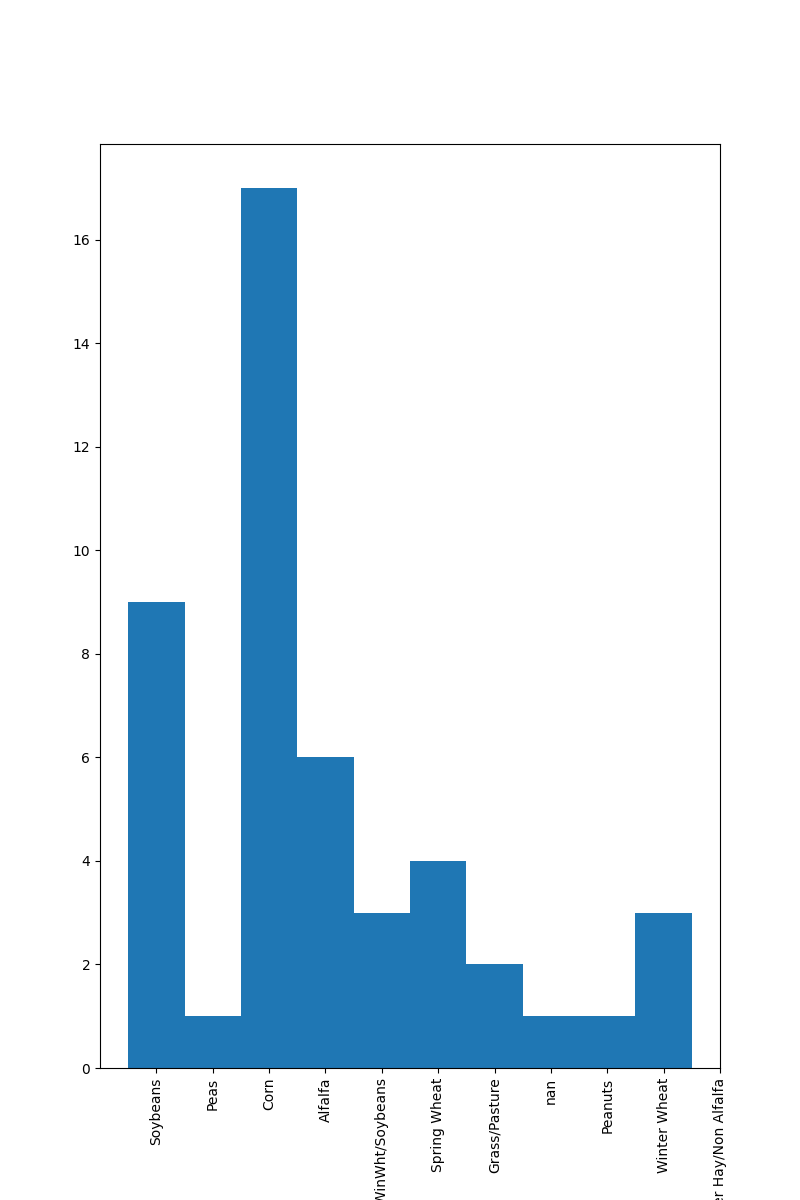

In [44]:
plt.figure(figsize=(8,12))
plt.hist([el['croptype'].iloc[0] for _, el in annotations_complete.groupby(['sfd_id', 'year'])], bins='auto', align='left')
plt.xticks(rotation=90)
plt.show()

In [45]:
annotations_complete.loc[:, ['sfd_id', 'year', 'croptype']]

,sfd_id,year,croptype
0,102247581,2018,Alfalfa
1,102247581,2018,Alfalfa
2,102174002,2018,Dbl Crop WinWht/Soybeans
3,102202245,2018,Corn
4,102202245,2018,Corn
5,102058667,2018,Soybeans
6,102077408,2018,Spring Wheat
7,102112829,2018,Corn
8,102002234,2018,Peas
9,102006400,2018,Alfalfa


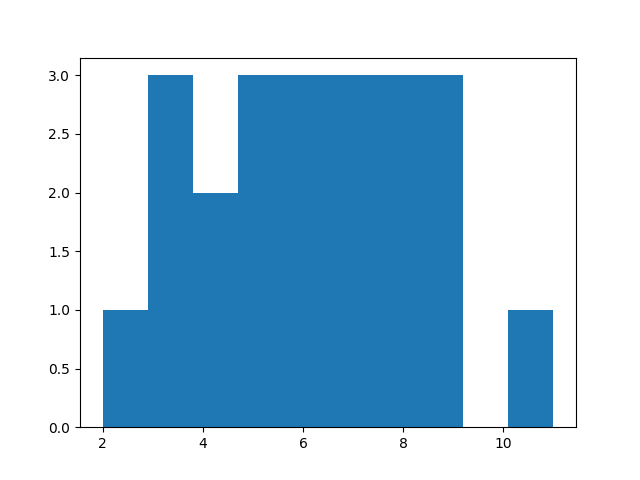

In [46]:
plt.figure()
plt.hist(date_of_pinnotes[(annotations_complete.croptype == 'Corn') | (annotations_complete.croptype == 'Soybean')].month)
plt.show()

In [47]:
pd.read_csv('pinnote_anomaly_info/annotations_valid_dates.csv', sep=';')['sfd_id'].unique().__len__()

47

In [48]:
pd.read_csv('pinnote_anomaly_info/annotations_valid_dates.csv', sep=';')['spn_id'].unique().__len__()

57

### Final annotations

In [49]:
pd.read_csv('pinnote_anomaly_info/annotations_dates_params.csv', sep=';')['sfd_id'].unique().__len__()

43

In [50]:
pd.read_csv('pinnote_anomaly_info/annotations_dates_params.csv', sep=';')['spn_id'].unique().__len__()

51

43 fields with in total 51 avalaible annotations

In [51]:
for el in pd.read_csv('pinnote_anomaly_info/annotations_valid_dates.csv', sep=';')['spn_id'].unique():
    if el not in pd.read_csv('pinnote_anomaly_info/annotations_dates_params.csv', sep=';')['spn_id'].unique():
        print(el)

8610
8833
8837
6994
10307
17370


In [52]:
all_annotes_dates = pd.read_csv('pinnote_anomaly_info/annotations_dates_params.csv', sep=';')
all_annotes_dates

,spn_id,sfd_id,spn_createdon,year,event_date,sigma,min_size,scale,para_comment
0,6413,102000576,22/12/2017 07:12,2017,17/07/2017,0,25,30,3 segments
1,6413,102000576,22/12/2017 07:12,2017,29/07/2017,0,25,35,7 segments
2,6991,102002234,08/03/2018 14:17,2018,08/06/2018,0,5,3,7 segments
3,6991,102002234,08/03/2018 14:17,2018,13/06/2018,0,5,5,7 segments
4,6991,102002234,08/03/2018 14:17,2018,15/06/2018,0,5,5,10 segments
...,...,...,...,...,...,...,...,...,...
557,18124,103023037,23/10/2019 19:45,2019,02/07/2019,0,10,10,7 segments
558,18124,103023037,23/10/2019 19:45,2019,13/07/2019,0,10,10,8 segemnts
559,18124,103023037,23/10/2019 19:45,2019,18/07/2019,0,10,10,11 segments
560,18124,103023037,23/10/2019 19:45,2019,06/10/2019,0,10,15,3 segments


In [53]:
all_annotes_dates.loc[:,['spn_id', 'sfd_id']].value_counts()

spn_id  sfd_id   
15358   102670816    38
15305   102721937    35
11835   102328550    29
17896   102622198    23
8559    102268387    22
15253   102623113    21
6548    102058667    20
8665    102248701    20
9951    102196663    16
9946    102196644    16
9945    102196644    16
9944    102196644    16
6991    102002234    15
17543   102943146    13
17542   102943146    13
11213   102019060    12
6632    102077408    12
12682   102424640    12
16142   102873222    11
15500   102564105    10
15584   102750316    10
14892   102620833    10
12681   102424640     9
7578    102174002     9
15588   102750358     9
7070    102130079     9
12684   102424640     9
11382   102006104     8
17438   102923614     8
9730    102103879     8
8251    102252397     7
7482    102066519     7
7480    102112067     7
6959    102112829     7
12278   102169942     6
14512   102645549     6
11105   102358920     6
18533   103016841     6
17355   102627215     6
18540   103016841     6
11676   102403591     

## Creation of binary anomaly annotations

In [54]:
from rasterio.plot import show

102112829_Bands_20180824_Sentinel2_Clear_137.gil
31


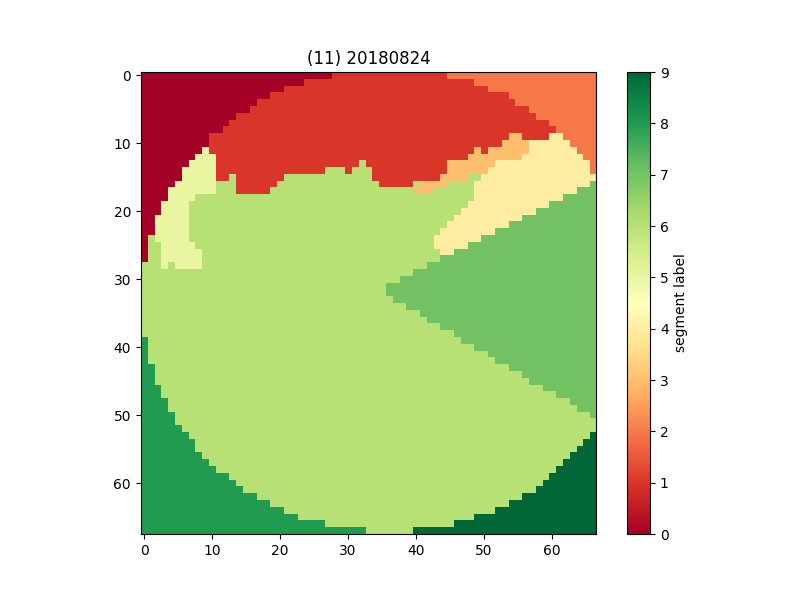

0 25 62


In [55]:
data_path = 'data_images_2017_2020/'

year_choice = 2018
#sfd_id_choice = 102424640
sfd_id_choice = 102112829
i = 11

# Parameters
sigma=0        # diameter of a Gaussian kernel, used for smoothing the image prior to segmentation.
min_size=25

band_gil_file, band_tif_file, ndvi_tif_file = data_extractor(data_path, sfd_id_choice, year_choice)
mask_dict, tif_info = resize_ndvi(data_path, ndvi_tif_file, sfd_id_choice)
img_band_gil = data_path + str(sfd_id_choice)+ '/' + band_gil_file[i]
img_band_tif = data_path + str(sfd_id_choice) + '/' + band_tif_file[i]
img_ndvi_tif = data_path + str(sfd_id_choice) + '/' + ndvi_tif_file[i]  # Bands and NDVI images are by the same date order
print(band_gil_file[i])
date_choice = band_gil_file[i].split('_')[2]

# raster band
bands_green_red_nir = get_band_order_GS2(img_band_gil, ['green', 'red', 'nir'])
raster_band = rasterio.open(img_band_tif)
raster_band_numpy = raster_band.read(bands_green_red_nir, masked=True) # attention masked # channel order : (3, height, width)
            
# raster ndvi
raster_ndvi = rasterio.open(img_ndvi_tif)
raster_ndvi_numpy = raster_ndvi.read(1, masked=True)
# resize the NDVI images
raster_ndvi_numpy = resample(raster_ndvi_numpy, mask_dict[sfd_id_choice])   
            
# resize bands images according to the unified NDVI images
raster_resampled_1 = resample(raster_band_numpy[0,:,:], raster_ndvi_numpy).filled(np.nan)
raster_resampled_2 = resample(raster_band_numpy[1,:,:], raster_ndvi_numpy).filled(np.nan)
raster_resampled_3 = resample(raster_band_numpy[2,:,:], raster_ndvi_numpy).filled(np.nan)
raster_band_numpy_resampled = np.stack((raster_resampled_1, raster_resampled_2, raster_resampled_3), axis=0)
raster_band_numpy_resampled = np.ma.masked_invalid(raster_band_numpy_resampled) # raster_band_numpy resampled with mask # not filled()
            
# Segmentation 
# parameter 'scale' is proportional to the number of valide pixels for an image
num_valid_pixels = np.sum(~raster_band_numpy_resampled[0,:,:].mask)
print(num_valid_pixels//100)
scale = 62
num_valid_pixels//100
            
# segment each band image 
raster_band_numpy_seg = np.transpose(raster_band_numpy_resampled, (1,2,0)) # channel : (width, height, 3) or (width, height) ndarray for segmentation
raster_band_numpy_seg = raster_band_numpy_seg.filled(-1)
segments_fz = felzenszwalb(raster_band_numpy_seg, scale=scale, sigma=sigma, min_size=min_size)

plt.close('all')
plt.figure(figsize=(8,6))
f1 = plt.imshow(segments_fz, cmap='RdYlGn')
plt.colorbar(f1, label='segment label')
plt.title(f"({i}) {date_choice}")
plt.show()
print(sigma, min_size, scale)

C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


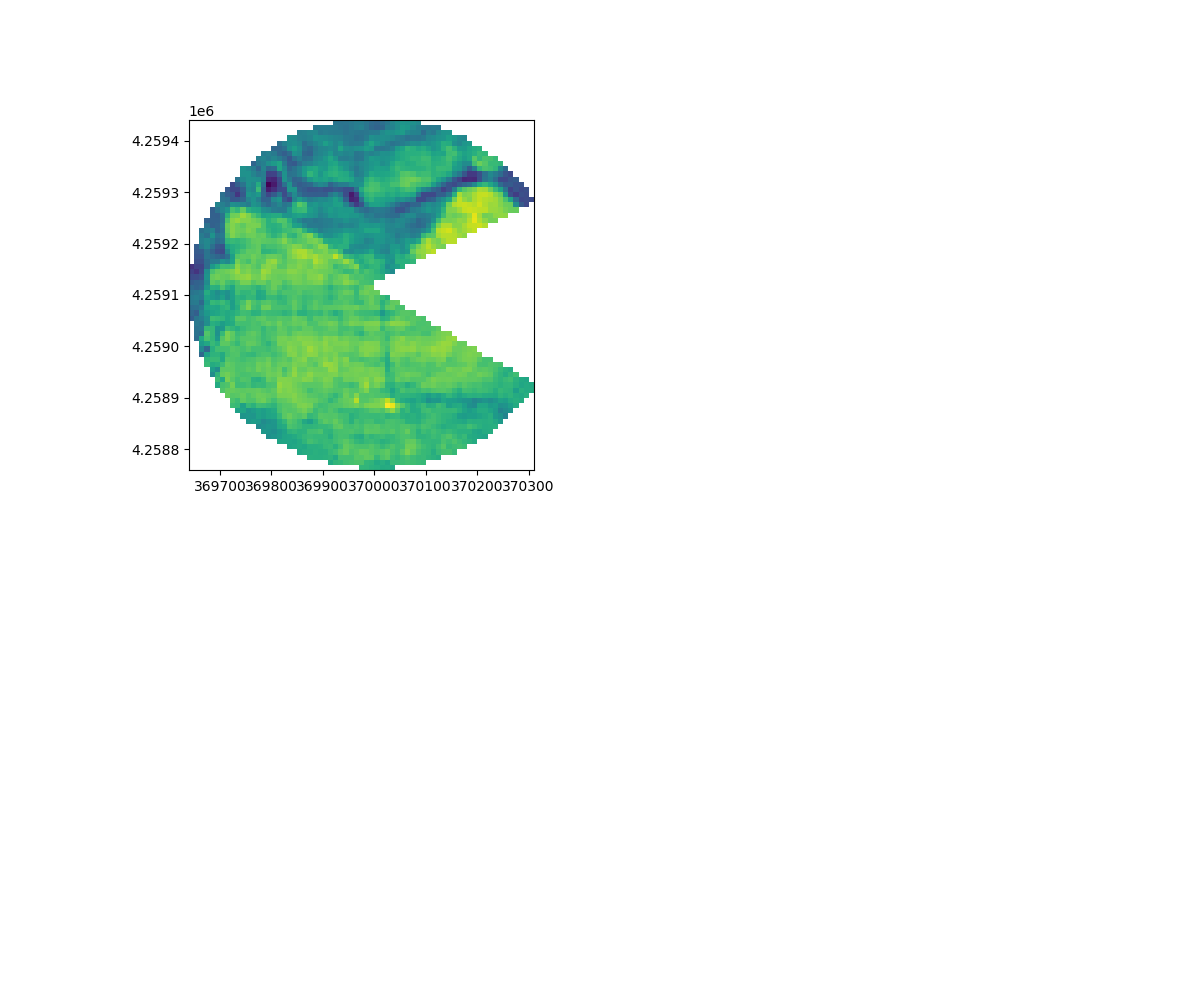

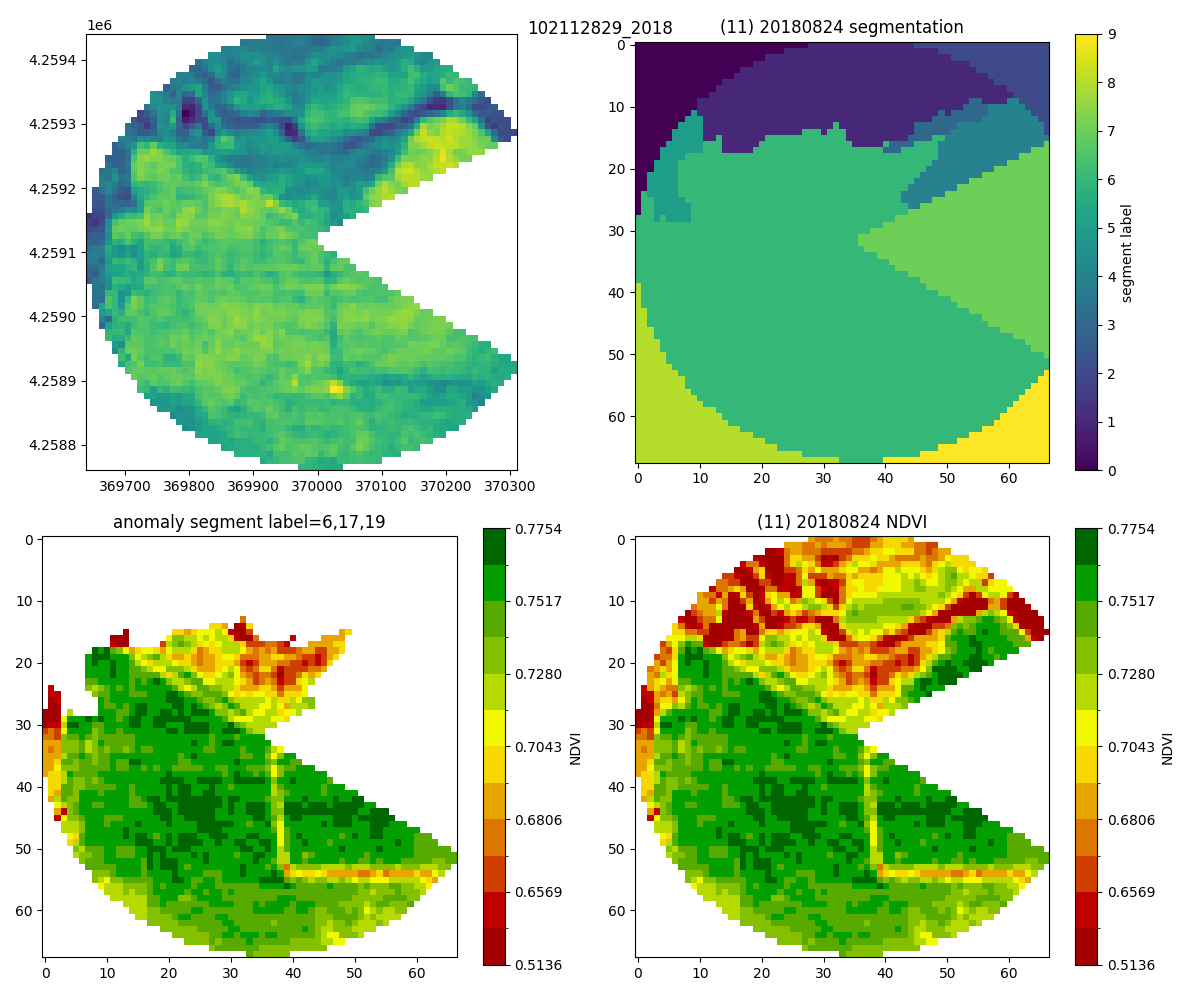

In [56]:
seg_label = 6
flag = 1

plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
show(raster_band)

plt.subplot(2,2,2)
f1 = plt.imshow(segments_fz)
plt.colorbar(f1, label='segment label')
plt.title(f"({i}) {date_choice} segmentation")

plt.subplot(2,2,3)
bb_annotes = copy.deepcopy(raster_ndvi_numpy)
# bb_annotes.mask += ~(segments_fz == seg_label)
bb_annotes.mask += ~( (segments_fz == seg_label)+(segments_fz ==17)+(segments_fz ==19) )

cmap, norm = get_palette(raster_ndvi_numpy)
f1 = plt.imshow(bb_annotes, cmap=cmap, norm=norm)
plt.colorbar(f1, label='NDVI')
plt.title(f"anomaly segment label={seg_label},17,19")

plt.subplot(2,2,4)
# cmap, norm = get_palette(raster_ndvi_numpy)
f1 = plt.imshow(raster_ndvi_numpy, cmap=cmap, norm=norm)
plt.colorbar(f1, label='NDVI')
plt.title(f"({i}) {date_choice} NDVI")
plt.tight_layout()
plt.suptitle(f'{sfd_id_choice}_{year_choice}')
'''
if flag == 1:
    if not os.path.exists(f'pinnote_anomaly_info/annotations_seg_parameters/{sfd_id_choice}/'):
        os.makedirs(f'pinnote_anomaly_info/annotations_seg_parameters/{sfd_id_choice}/')
    plt.savefig(f'pinnote_anomaly_info/annotations_seg_parameters/{sfd_id_choice}/{sfd_id_choice}_{year_choice}_{date_choice}_scale_{scale}_sigma_{sigma}_minsize_{min_size}.png',
                format='png')
'''
plt.show()

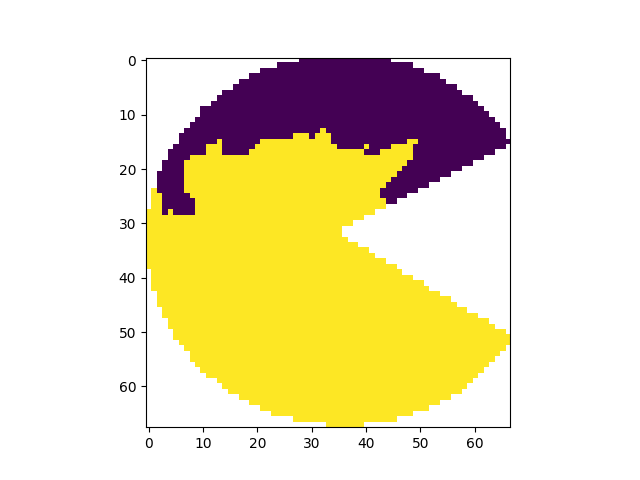

In [57]:
bi_annotes = np.ma.zeros(raster_ndvi_numpy.shape)
bi_annotes[segments_fz == seg_label] = 1
bi_annotes[segments_fz == 19]= 1
bi_annotes[segments_fz == 17]= 1

# bi_annotes[:20,:] =0
# bi_annotes[:,:23] =0

bi_annotes[raster_ndvi_numpy.mask] = -999
bi_annotes.mask = copy.deepcopy(raster_ndvi_numpy).mask
bi_annotes

plt.figure()
plt.imshow(bi_annotes)
plt.show()

### Save annotated coverage TIFF

In [59]:
def open_tiff(path, name):
    ds = gdal.Open(path+"/"+name+".TIF")
    geo = ds.GetGeoTransform()
    proj = ds.GetProjection()
    bands_nb = ds.RasterCount
    W = ds.RasterXSize
    H = ds.RasterYSize
    try:
        image_array = gdal_array.LoadFile(path + "/" + name+".TIF")
    except:
        image_array = gdal_array.LoadFile(path + name+".TIF")
    ds = None
    return np.asarray(image_array), H, W, geo, proj, bands_nb

def create_tiff(nb_channels, new_tiff_name, width, height, datatype, data_array, geotransformation, projection):
    dst_ds = driver_tiff.Create(new_tiff_name, width, height, nb_channels, datatype)
    if nb_channels == 1:
        dst_ds.GetRasterBand(1).WriteArray(data_array)
    else:
        for ch in range(nb_channels):
            dst_ds.GetRasterBand(ch + 1).WriteArray(data_array[ch])
    dst_ds.GetRasterBand(1).SetNoDataValue(-999)
    dst_ds.SetGeoTransform(geotransformation)
    dst_ds.SetProjection(projection)
    return dst_ds

In [60]:
driver_tiff = gdal.GetDriverByName("GTiff")
_, H, W, geo, proj, bands_nb = open_tiff(data_path + str(sfd_id_choice), ndvi_tif_file[i].strip('.tif'))
if H != mask_dict[sfd_id_choice].shape[0] or W != mask_dict[sfd_id_choice].shape[1]:
    H, W = mask_dict[sfd_id_choice].shape
    geo = tif_info['transform'].to_gdal()
save_path = f"pinnote_anomaly_info/annotations/{sfd_id_choice}/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
img_name = "pinnote_anomaly_info/annotations/"+str(sfd_id_choice)+"/"+str(sfd_id_choice)+"_"+str(year_choice)+"_"+str(date_choice)+".tif"
ds = create_tiff(1, img_name, W, H, gdal.GDT_Float64, bi_annotes, geo, proj)

C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [61]:
saved_annote = rasterio.open(img_name)
saved_annote_np = saved_annote.read(1, masked=True)
plt.figure()
plt.imshow(saved_annote_np)
plt.show()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "rasterio\_base.pyx", line 308, in rasterio._base.DatasetBase.__init__
  File "rasterio\_base.pyx", line 219, in rasterio._base.open_dataset
  File "rasterio\_err.pyx", line 221, in rasterio._err.exc_wrap_pointer
rasterio._err.CPLE_OpenFailedError: 'pinnote_anomaly_info/annotations/102112829/102112829_2018_20180824.tif' not recognized as a supported file format.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\qle\AppData\Local\Temp\ipykernel_22660\541844758.py", line 1, in <module>
    saved_annote = rasterio.open(img_name)
                   ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\rasterio\env.py", line 451, in wrapper
    return f

## Visualization of all NDVI images

In [62]:
plt.close('all')
raster_df_save_path = 'variables/raster_df'
year_choice = 2018
sfd_choice = 102620833

raster_df = pd.read_pickle(f'{raster_df_save_path}/{year_choice}/{sfd_choice}_{year_choice}_raster_seg_df.pkl')
sfd_id_choice = x.split('_')[0]
date_list = raster_df['raster_ndvi_numpy'].index.strftime('%Y-%m-%d')

n_col = 4
n_row = math.ceil(len(date_list)/n_col)
plt.figure(figsize=(n_col*4,n_row*4))
for i, date_choice in enumerate(date_list):
    raster_ndvi_numpy = raster_df.loc[date_choice, 'raster_ndvi_numpy']

    plt.subplot(n_row,n_col,i+1)
    cmap, norm = get_palette(raster_ndvi_numpy)
    f1 = plt.imshow(raster_ndvi_numpy, cmap=cmap, norm=norm)
    plt.colorbar(f1, label='NDVI')
    plt.title(f"({i}) {date_choice}")

plt.suptitle(f'NDVI images of the field {sfd_id_choice} in {year_choice}', y=0.99)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'variables/raster_df/2018/102620833_2018_raster_seg_df.pkl'

### Save NDVI, segmentation results series

In [63]:
raster_df_save_path = 'variables/raster_df/'
seasons = [2017, 2018, 2019, 2020]
for year_choice in seasons: 
    raster_df_all = os.listdir(raster_df_save_path + str(year_choice) + '/')

    for x in raster_df_all:
        raster_df = pd.read_pickle(raster_df_save_path + str(year_choice) + '/' + x)
        sfd_id_choice = x.split('_')[0]
        date_list = raster_df['raster_ndvi_numpy'].index.strftime('%Y-%m-%d')
        
        n_col = 4
        n_row = math.ceil(len(date_list)/n_col)
        plt.figure(figsize=(n_col*4,n_row*4))
        for i, date_choice in enumerate(date_list):
            raster_ndvi_numpy = raster_df.loc[date_choice, 'raster_ndvi_numpy']

            plt.subplot(n_row,n_col,i+1)
            cmap, norm = get_palette(raster_ndvi_numpy)
            f1 = plt.imshow(raster_ndvi_numpy, cmap=cmap, norm=norm)
            plt.colorbar(f1, label='NDVI')
            plt.title(f"({i}) {date_choice}")

        plt.suptitle(f'NDVI images of the field {sfd_id_choice} in {year_choice}', y=0.99)
        plt.tight_layout()

        plt.savefig(f'image_results/NDVI_images/{sfd_id_choice}_{year_choice}_ndvi_images.png', format='png')

        plt.show()
        plt.close('all')

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'variables/raster_df/2017/'

In [75]:
raster_df_save_path = 'variables/raster_df/'
seasons = [2017, 2018, 2019, 2020]
for year_choice in seasons: 
    raster_df_all = os.listdir(raster_df_save_path + str(year_choice) + '/')

    for x in raster_df_all:
        raster_df = pd.read_pickle(raster_df_save_path + x)
        sfd_id_choice = x.split('_')[0]
        date_list = raster_df['segments_fz'].index.strftime('%Y-%m-%d')

        n_col = 4
        n_row = math.ceil(len(date_list)/n_col)
        plt.figure(figsize=(n_col*4,n_row*4))
        for i, date_choice in enumerate(date_list):
            segments_fz = raster_df.loc[date_choice, 'segments_fz']

            plt.subplot(n_row,n_col,i+1)
            f1 = plt.imshow(segments_fz)
            plt.colorbar(f1, label='segment label')
            plt.title(f"({i}) {date_choice}")

        plt.suptitle(f'Segmentation of the field {sfd_id_choice} in {year_choice}', y=0.99)
        plt.tight_layout()

        plt.savefig(f'image_results/Segmentation_results/{sfd_id_choice}_{year_choice}_segmentation_images.png', format='png')
        plt.show()
        plt.close('all')

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'variables/raster_df/2017/'

### Save those of verified anomalies by anomaly type

In [64]:
raster_df_save_path = 'variables/raster_df/'

for a in anomaly:
    a_sfd = selected_data[selected_data.anomaly == a].spn_idseasonfieldr7.values
    years = selected_data[selected_data.anomaly == a].year.values
    for i, sfd_id_choice in enumerate(a_sfd):
        year_choice = years[i]
        raster_df_all = os.listdir(raster_df_save_path + str(year_choice) + '/')
        raster = str(sfd_id_choice)+'_'+str(year_choice)+'_raster_seg_df.pkl'
        if raster in raster_df_all:
            raster_df = pd.read_pickle(raster_df_save_path + str(year_choice) + '/' + raster)#f'variables/raster_df/{sfd_id_choice}_{year_choice}_raster_seg_df.pkl')
            date_list = raster_df['raster_ndvi_numpy'].index.strftime('%Y-%m-%d')

            n_col = 4
            n_row = math.ceil(len(date_list)/n_col)
            plt.figure(figsize=(n_col*4,n_row*4))
            for i, date_choice in enumerate(date_list):
                raster_ndvi_numpy = raster_df.loc[date_choice, 'raster_ndvi_numpy']

                plt.subplot(n_row,n_col,i+1)
                cmap, norm = get_palette(raster_ndvi_numpy)
                f1 = plt.imshow(raster_ndvi_numpy, cmap=cmap, norm=norm)
                plt.colorbar(f1, label='NDVI')
                plt.title(f"({i}) {date_choice}")

            plt.suptitle(f'NDVI images of the field {sfd_id_choice} in {year_choice}', y=0.99)
            plt.tight_layout()

            savepath = 'pinnote_anomaly_info/pinnote_anomaly_NDVI_segmentation/'+str(a)+'/'
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            plt.savefig(f'pinnote_anomaly_info/pinnote_anomaly_NDVI_segmentation/{a}/{sfd_id_choice}_{year_choice}_ndvi_images.png', format='png')

            plt.show()
            plt.close('all')

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'variables/raster_df/2018/'

In [76]:
raster_df_save_path = 'variables/raster_df/'

for a in anomaly:
    a_sfd = selected_data[selected_data.anomaly == a].spn_idseasonfieldr7.values
    years = selected_data[selected_data.anomaly == a].year.values
    for i, sfd_id_choice in enumerate(a_sfd):
        year_choice = years[i]
        raster_df_all = os.listdir(raster_df_save_path + str(year_choice) + '/')
        raster = str(sfd_id_choice)+'_'+str(year_choice)+'_raster_seg_df.pkl'
        if raster in raster_df_all:
            raster_df = pd.read_pickle(raster_df_save_path + str(year_choice) + '/' + raster)#f'variables/raster_df/{sfd_id_choice}_{year_choice}_raster_seg_df.pkl')
            date_list = raster_df['segments_fz'].index.strftime('%Y-%m-%d')

            n_col = 4
            n_row = math.ceil(len(date_list)/n_col)
            plt.figure(figsize=(n_col*4,n_row*4))
            for i, date_choice in enumerate(date_list):
                segments_fz = raster_df.loc[date_choice, 'segments_fz']

                plt.subplot(n_row,n_col,i+1)
                f1 = plt.imshow(segments_fz)
                plt.colorbar(f1, label='segment label')
                plt.title(f"({i}) {date_choice}")

            plt.suptitle(f'Segmentation of the field {sfd_id_choice} in {year_choice}', y=0.99)
            plt.tight_layout()

            savepath = 'pinnote_anomaly_info/pinnote_anomaly_NDVI_segmentation/'+str(a)+'/'
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            plt.savefig(f'pinnote_anomaly_info/pinnote_anomaly_NDVI_segmentation/{a}/{sfd_id_choice}_{year_choice}_segmentation_images.png', format='png')

            plt.show()
            plt.close('all')

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'variables/raster_df/2018/'